In [1]:
import geopandas as gpd
from shapely import LineString, Polygon, Point
import shapely
from shapely import ops
import matplotlib.pyplot as plt
from CPP_Planner import CPP_Algorithms, CPP_Planner_Kit
from shapely import affinity
from skimage.measure import approximate_polygon
import math
import warnings
# warnings.filterwarnings('ignore')

In [2]:
all_land = gpd.read_file('test_Load_Shp/shp_file/村1地_全区.shp')
# 这里要控制精度
all_land.geometry = all_land.geometry.apply(shapely.set_precision, grid_size=0.05)
# 对当前 all_land 添加一个 mean_slope 字段 [3.37, 7.38, 6.07, 3.94, 6.53, 7.46, 7.62]
all_land['mean_slope'] = [3.37, 7.38, 6.07, 3.94, 6.53, 7.46, 7.62]

all_land

,NAME,LAYER,周长,闭合面积,geometry,mean_slope
0,地2,Unknown Area Type,315.38 m,0.001833 sq km,"POLYGON ((440417.600 4397401.450, 440401.850 4...",3.37
1,地3,Unknown Area Type,182.65 m,0.001528 sq km,"POLYGON ((440478.950 4397335.400, 440484.500 4...",7.38
2,地4,Unknown Area Type,247.41 m,0.00125 sq km,"POLYGON ((440472.250 4397608.050, 440469.000 4...",6.07
3,地5,Unknown Area Type,143.98 m,0.000743 sq km,"POLYGON ((440450.050 4397795.250, 440451.850 4...",3.94
4,地6,Unknown Area Type,120.25 m,0.000631 sq km,"POLYGON ((440352.800 4397768.750, 440351.250 4...",6.53
5,地7,Unknown Area Type,147.18 m,0.001222 sq km,"POLYGON ((440315.750 4397785.800, 440309.100 4...",7.46
6,地1_区,Unknown Area Type,442.09 m,0.004246 sq km,"POLYGON ((440410.850 4397414.750, 440398.850 4...",7.62


split_polygon_by_largest_area： 开始进行田块分割，当前误差范围 tolerance = 0.05
Num of convex_hull:  12
Num of Polygon lines:  20
Not on Convex:  11
Num of convex_hull:  7
Num of Polygon lines:  9
Not on Convex:  4


/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)


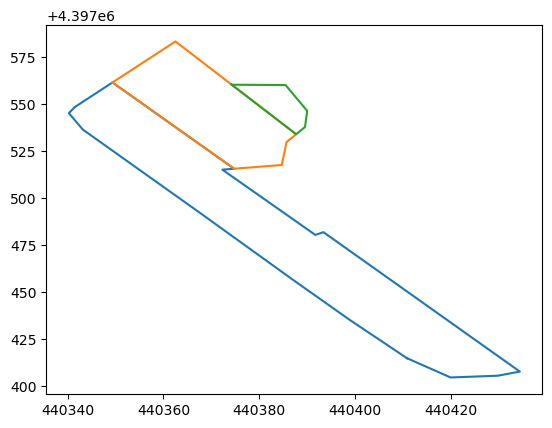

In [3]:
single_land = CPP_Planner_Kit.get_single_shp(all_land, 6)
# single_land.plot()
split_polygon = CPP_Planner_Kit.split_polygon_by_largest_area(single_land.geometry.iloc[0], tolerance=0.05)
_, ax = plt.subplots()
for polygon in split_polygon:
    ax.plot(*polygon.exterior.xy)

当前田块角度： 117.06086972480475


/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/constructive.py:1000: RuntimeWarning: invalid value encountered in oriented_envelope
  return lib.oriented_envelope(geometry, **kwargs)


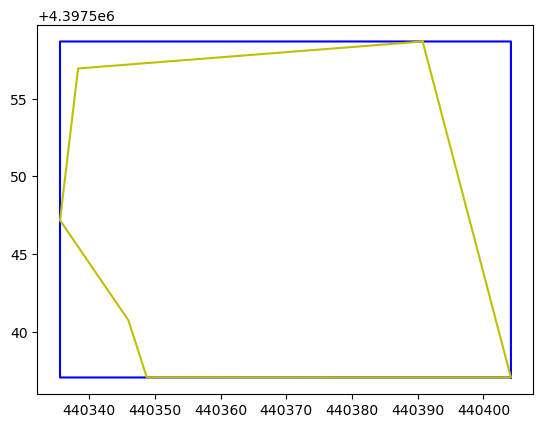

In [4]:
single_polygon = split_polygon[1]
single_polygon_angle = CPP_Planner_Kit.get_land_MABR_angle(single_polygon)
single_polygon = affinity.rotate(single_polygon, -single_polygon_angle, origin='centroid')
mabr = single_polygon.minimum_rotated_rectangle
_, ax = plt.subplots()
ax.plot(*mabr.exterior.xy, color='b')
ax.plot(*single_polygon.exterior.xy, color='y')

0    MULTIPOLYGON (((440404.111 4397537.057, 440404...
dtype: geometry


/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)
/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/set_operations.py:77: RuntimeWarning: invalid value encountered in difference
  return lib.difference(a, b, **kwargs)
/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


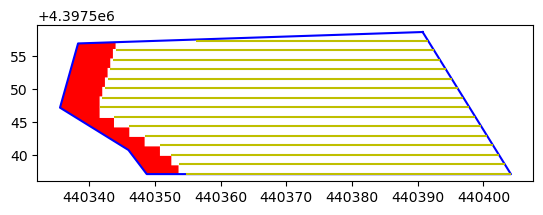

In [5]:
corrected_swath_width = CPP_Planner_Kit.get_corrected_swath_width(swath_width=1.45, slope=6)
path, headland = CPP_Algorithms.scanline_algorithm_single_with_headland(
    land=gpd.GeoDataFrame(geometry=[single_polygon]), step_size=corrected_swath_width, along_long_edge=False,
    headland='left', head_land_width=6
)
# 显示
_, ax = plt.subplots()
ax.plot(*single_polygon.exterior.xy, 'b')
path.plot(ax=ax, color='y')
headland.plot(ax=ax, color='r')
print(headland)

#### 开始测试生成转向的路径

In [6]:
from shapely.geometry import MultiLineString

# 计算地块和耕作路径的交集
single_split_land = gpd.GeoDataFrame(geometry=[single_polygon])
path_geometry = path.geometry

In [7]:
path_geometry.head(5)

0    LINESTRING (440404.111 4397537.157, 440354.693...
1    LINESTRING (440403.216 4397538.599, 440353.598...
2    LINESTRING (440402.320 4397540.041, 440352.503...
3    LINESTRING (440401.425 4397541.483, 440350.768...
4    LINESTRING (440400.529 4397542.925, 440348.438...
Name: geometry, dtype: geometry

#### 测试计算地头长度


In [8]:
def calc_headland_width(turning_radius: float, swath_width: float, vehicle_length: float, vehicle_width: float):
    # 计算求得车转向的角度
    theta = math.asin(swath_width / (2 * vehicle_length))
    print("theta ", theta)
    # 计算车辆左上角顶点到转向圆心的距离 r2
    r2 = math.sqrt((turning_radius + vehicle_width / 2) ** 2 + (vehicle_length / 2) ** 2)
    print("r2: ", r2)
    theta2 = math.asin(vehicle_length / (2 * r2))
    print("theta2 ", theta2)
    # 计算车辆转向时的水平移动距离
    w2 = r2 * math.sin(theta + theta2)
    print("w2: ", w2)
    final_width = w2 + vehicle_length / 2
    print("地块宽度: ", final_width)
    return final_width

In [9]:
headland_width = calc_headland_width(turning_radius=4.5, swath_width=1.45, vehicle_length=6.3, vehicle_width=2)
print(headland_width)

theta  0.11533489518152089
r2:  6.3381779716255995
theta2  0.5201245875154694
w2:  3.7620088544954675
地块宽度:  6.912008854495467
6.912008854495467


In [10]:
# 测试 CPP_Planner 中的代码
CPP_Planner_Kit.calc_headland_width(turning_radius=4.5, swath_width=1.45, vehicle_length=6.3, vehicle_width=2,
                                    show_info=True)

Theta:  0.6682897949014295
r2:  6.3381779716255995
Theta2:  0.5201245875154695
w2: 5.880425188012902
Buffer:  0.0
最终地头宽度:  9.030425188012902


(9.030425188012902, 0.6682897949014295)

### 生成转向的路径

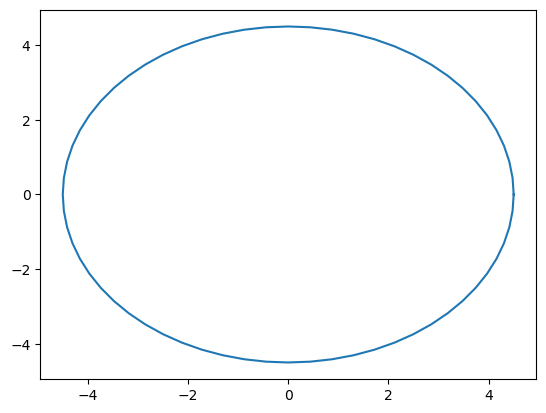

In [11]:
from shapely.geometry import LinearRing
from math import pi

# 绘制圆弧测试
center = Point(0, 0)
turning_radius = 4.5
start_angle = 0
end_angle = pi / 2

circle = center.buffer(turning_radius)
plt.plot(*circle.exterior.xy)

In [12]:
# 绘制一条 S 型的dubins curve
# 1. 先绘制一个圆弧
center = Point(0, 0)
turning_radius = 4.5
start_angle = 0
end_angle = pi / 2

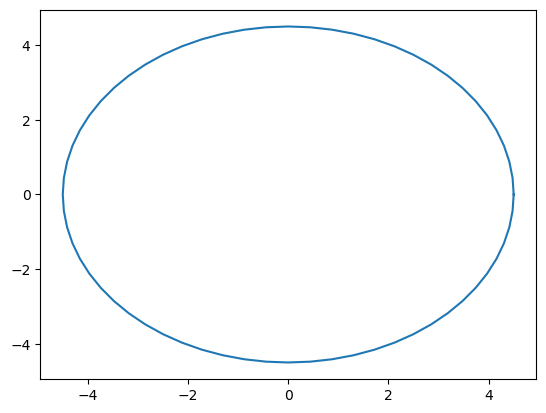

In [13]:
circle = center.buffer(turning_radius)
plt.plot(*circle.exterior.xy)

/var/folders/r2/bv03lgdn7y58thlc1ntrzgvc0000gn/T/ipykernel_33004/244704350.py:6: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  arc = Arc(center, 2 * radius, 2 * radius, 0, start_angle, end_angle, color=color)


Text(0.5, 1.0, 'Arc Example')

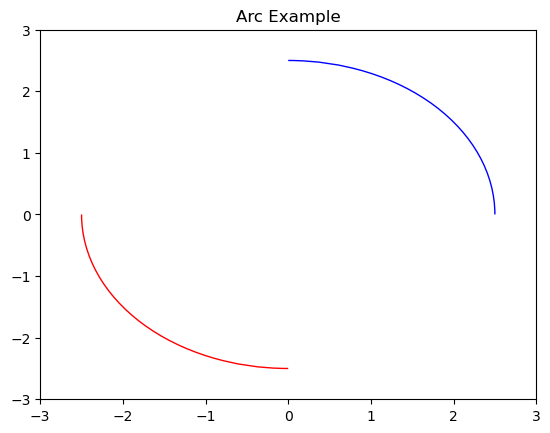

In [14]:
from matplotlib.patches import Arc


def plot_arc(center, radius, start_angle, end_angle, color):
    # 创建Arc对象
    arc = Arc(center, 2 * radius, 2 * radius, 0, start_angle, end_angle, color=color)

    # 获取当前坐标轴对象
    ax = plt.gca()

    # 添加Arc对象到坐标轴
    ax.add_patch(arc)


# 定义圆心、半径和角度范围
center = (0, 0)
radius = 2.5
start_angle = 0
end_angle = 90

# 绘制左转弧线
plot_arc(center, radius, start_angle, end_angle, color='blue')

# 绘制右转弧线
plot_arc(center, radius, start_angle + 180, end_angle + 180, color='red')

# 设置坐标轴范围
plt.xlim(-3, 3)
plt.ylim(-3, 3)

# 添加标题
plt.title('Arc Example')

/var/folders/r2/bv03lgdn7y58thlc1ntrzgvc0000gn/T/ipykernel_33004/3218846542.py:59: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  arc = Arc((0, 0), 2.5, 4.5, 0, 0, 90)


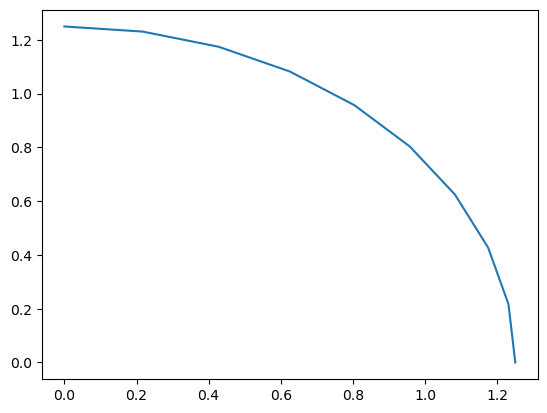

In [15]:
import numpy as np


def arc_to_linestring_1(arc):
    # 获取Arc的起始点和终止点坐标
    x0, y0 = arc.center
    radius = arc.width / 2.0
    theta1 = arc.theta1
    theta2 = arc.theta2

    print(f'{x0}, {y0}, {radius}, {theta1}, {theta2}')

    # 将起始点和终止点的坐标转换为LineString的坐标列表
    start_point = (x0 + radius * np.cos(np.deg2rad(theta1)), y0 + radius * np.sin(np.deg2rad(theta1)))
    print("Start point: ", start_point)
    end_point = (x0 + radius * np.cos(np.deg2rad(theta2)), y0 + radius * np.sin(np.deg2rad(theta2)))
    print("End point: ", end_point)
    coordinates = [start_point, end_point]
    print("Coordinates: ", coordinates)

    # 创建LineString对象
    linestring = LineString(coordinates)

    return linestring


def arc_to_linestring(arc, degree_step):
    # 获取Arc的起始点和终止点坐标
    x0, y0 = arc.center
    radius = arc.width / 2.0
    theta1 = arc.theta1
    theta2 = arc.theta2

    # 将起始点和终止点的坐标转换为LineString的坐标列表
    start_point = (x0 + radius * np.cos(np.deg2rad(theta1)), y0 + radius * np.sin(np.deg2rad(theta1)))
    end_point = (x0 + radius * np.cos(np.deg2rad(theta2)), y0 + radius * np.sin(np.deg2rad(theta2)))
    coordinates = [start_point]

    # 根据degree_step计算中间点的坐标
    if theta2 > theta1:
        angles = np.arange(theta1, theta2, degree_step)
    else:
        angles = np.arange(theta1, theta2 + 360, degree_step)

    for angle in angles:
        x = x0 + radius * np.cos(np.deg2rad(angle))
        y = y0 + radius * np.sin(np.deg2rad(angle))
        coordinates.append((x, y))

    coordinates.append(end_point)

    # 创建LineString对象
    linestring = LineString(coordinates)

    return linestring


# 创建一个Arc对象
arc = Arc((0, 0), 2.5, 4.5, 0, 0, 90)

# 将Arc对象转换为LineString对象
linestring = arc_to_linestring(arc, 10)
plt.plot(*linestring.xy)

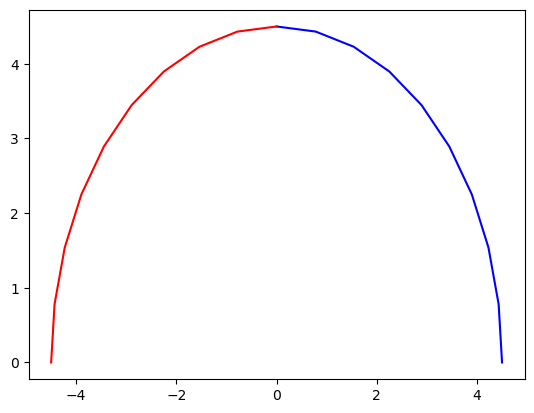

In [16]:
# 测试 基础圆弧生成
from CPP_Planner import CPP_Planner_TurningRail_Maker

curve = CPP_Planner_TurningRail_Maker.gen_single_curve((0, 0), 4.5, 10, 0, pi / 2)
curve2 = CPP_Planner_TurningRail_Maker.gen_single_curve((0, 0), 4.5, 10, pi / 2, pi)
_, ax = plt.subplots()
ax.plot(*curve.xy, 'b')
ax.plot(*curve2.xy, 'r')

##### 测试生成一个 S 形状的地头，能够让 农机 从 一条 swath 移动到另一条 swath 上面

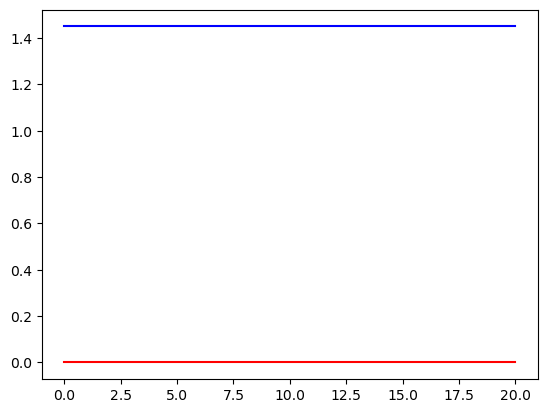

In [17]:
# 假设两条耕作路径的长度均为 20m，平行且水平，宽度为 1.45
swath1 = LineString(((0, 1.45), (20, 1.45)))
swath2 = LineString(((0, 0), (20, 0)))
_, ax = plt.subplots()
ax.plot(*swath1.xy, 'b')
ax.plot(*swath2.xy, 'r')

In [18]:
turning_radius = 4.5
swath_width = 1.45
vehicle_length = 6.3
vehicle_width = 1.9
# 获得地头长度，以及所需的旋转弧度
headland_width, theta = CPP_Planner_Kit.calc_headland_width(turning_radius=turning_radius, swath_width=swath_width,
                                                            vehicle_length=vehicle_length, vehicle_width=1.9, buffer=0.5,
                                                            show_info=True)
print(theta)
print(turning_radius)

Theta:  0.6682897949014295
r2:  6.294839156007086
Theta2:  0.5240721827749459
w2: 5.849442958825377
Buffer:  0.5
最终地头宽度:  9.499442958825377
0.6682897949014295
4.5


In [19]:
# 获取两个圆心的位置
print(swath1.coords[0][1])
center1 = (swath1.coords[1][0], swath1.coords[1][1] - turning_radius)
center2 = (swath2.coords[1][0] - 2 * (turning_radius * math.sin(theta)), swath2.coords[1][1] + turning_radius)
print("center1: ", center1, "  center2: ", center2)

1.45
center1:  (20.0, -3.05)   center2:  (14.42319874624548, 4.5)


0.9680286037355139


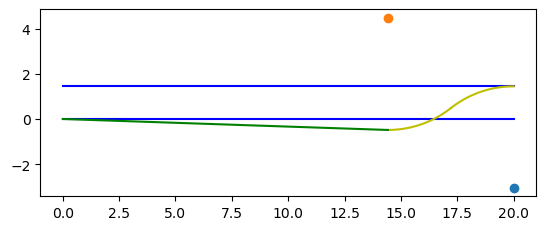

In [20]:
# 根据两个圆心绘制弧线
curve_1 = CPP_Planner_TurningRail_Maker.gen_single_curve(
    center1, turning_radius, 0.1, pi / 2, theta + pi / 2
)
curve_2 = CPP_Planner_TurningRail_Maker.gen_single_curve(
    center2, turning_radius, 0.1, -pi / 2, -pi / 2 + theta
)
# 因为转向半径过大的缘故，无法直接转到下一根路径上
turning_gap = abs(curve_2.coords[-1][1] - curve_1.coords[-1][1])
print(curve_2.coords[-1][1])
curve_2_offset = affinity.translate(curve_2, xoff=0, yoff=-turning_gap)

back_move_line = LineString((curve_2_offset.coords[0], swath2.coords[0]))

_, ax = plt.subplots()
# 绘制整个形状
ax.plot(*swath1.xy, 'b')
ax.plot(*swath2.xy, 'b')
ax.plot(*curve_1.xy, 'y')
ax.plot(*curve_2_offset.xy, 'y')
ax.plot(*back_move_line.xy, 'g')
ax.scatter(*center1)
ax.scatter(*center2)
ax.set_aspect('equal')

In [21]:
print(theta)
print(np.rad2deg(theta))
print(curve_1.coords[-1])
print(curve_2.coords[-1])

0.6682897949014295
38.29018473951531
(17.21159937312274, 0.48197139626448626)
(17.21159937312274, 0.9680286037355139)


In [22]:
center1[0] - center2[0]

5.576801253754519

In [23]:
vehicle_length = 6.3
vehicle_width = 1.9
turning_radius = 4.5
h = 1.45

theta = math.acos((turning_radius - h / 2) / turning_radius)
print(theta, " ", math.degrees(theta))
radius_2 = math.sqrt((turning_radius + vehicle_width / 2) ** 2 + (vehicle_length / 2) ** 2)
print("radius_2: ", radius_2)
theta_2 = math.atan((vehicle_length / 2) / (turning_radius + vehicle_width / 2))
print(theta_2, " ", math.degrees(theta_2))
min_width = radius_2 * math.sin(theta + theta_2)
print("最小地头宽度：", min_width + vehicle_length / 2)

0.5755576749735469   32.977025642346646
radius_2:  6.294839156007086
0.5240721827749459   30.027124233213083
最小地头宽度： 8.75894972937577


In [24]:
width_2 = turning_radius * math.sin(theta)
print(width_2 * 2)

4.8987243237398035


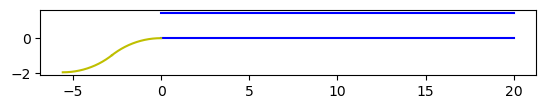

In [25]:
# 绘制整个形状，测试修正
curve_1_normalized = affinity.translate(curve_1, xoff=-curve_1.coords[0][0], yoff=-curve_1.coords[0][1])
curve_2_normalized = affinity.translate(curve_2_offset, xoff=-curve_1.coords[0][0], yoff=-curve_1.coords[0][1])
_, ax = plt.subplots()
ax.plot(*swath1.xy, 'b')
ax.plot(*swath2.xy, 'b')
ax.plot(*curve_1_normalized.xy, 'y')
ax.plot(*curve_2_normalized.xy, 'y')
ax.set_aspect('equal')

#### 测试

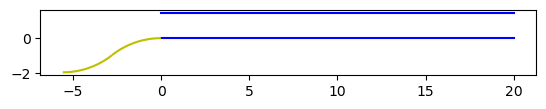

In [28]:
s_cur = CPP_Planner_TurningRail_Maker.gen_S_shape_curve(turning_radius, degree_step=0.1, vehicle_length=6.3,
                                                        vehicle_width=vehicle_width, swath_width=swath_width,
                                                        buffer=0.5)
_, ax = plt.subplots()
ax.plot(*swath1.xy, 'b')
ax.plot(*swath2.xy, 'b')
s_cur.plot(ax=ax, color='y')
ax.set_aspect('equal')